In [1]:
# Load and evaluate the existing test.csv to verify the score
try:
    test_df = pd.read_csv('test.csv')
    print("Loaded test.csv")
    
    # Parse the 's' prefix
    def parse_s(val):
        return float(val.replace('s', ''))
    
    test_df['x'] = test_df['x'].apply(parse_s)
    test_df['y'] = test_df['y'].apply(parse_s)
    test_df['deg'] = test_df['deg'].apply(parse_s)
    
    # Reconstruct trees and calculate score
    total_test_score = 0
    for n in range(1, 201):
        # Get rows for this N
        # The ID format is N_i, e.g., 001_0
        # We need to filter by the prefix
        prefix = f"{n:03d}_"
        rows = test_df[test_df['id'].str.startswith(prefix)]
        
        if len(rows) != n:
            print(f"Warning: N={n} has {len(rows)} rows, expected {n}")
            continue
            
        trees = []
        for _, row in rows.iterrows():
            trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
            
        side = get_bounds(trees)
        score_n = (side ** 2) / n
        total_test_score += score_n
        
    print(f"Score of test.csv: {total_test_score:.4f}")
    
except Exception as e:
    print(f"Could not evaluate test.csv: {e}")

Could not evaluate test.csv: name 'pd' is not defined


In [2]:
## 2. Setup

import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
from tqdm.notebook import tqdm

# Set random seed
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)

# High precision for coordinates
getcontext().prec = 50

print("Libraries imported and seed set.")

Libraries imported and seed set.


In [3]:
## 3. Load Data

# Load the sample submission to understand the required output format
try:
    sample_sub = pd.read_csv('test.csv')
    print("Sample Submission Shape:", sample_sub.shape)
    print(sample_sub.head())
except FileNotFoundError:
    print("Sample submission not found, proceeding without it.")

Sample Submission Shape: (20100, 4)
      id             x             y              deg
0  001_0  s-0.04236868  s0.125729391            s45.0
1  002_1   s0.32067493   s0.21329442    s23.630851287
2  002_0    s0.6288588    s0.7362252  s-156.370226241
3  003_1     s1.017555     s1.154083      s155.134174
4  003_0     s1.609898     s1.249622       s66.370481


## 4. Baseline Strategy

We define the `GreedyPacker` class here. It encapsulates the logic for placing a single tree into an existing configuration.

In [4]:
class GreedyPacker:
    def __init__(self, n_trials=100, step_size=0.2, fine_step=0.02):
        self.n_trials = n_trials
        self.step_size = step_size
        self.fine_step = fine_step

    def _generate_weighted_angle(self):
        """
        Generates a random angle with a distribution weighted by abs(sin(2*angle)).
        This helps place more trees in corners (diagonals).
        """
        while True:
            angle = random.uniform(0, 2 * math.pi)
            if random.uniform(0, 1) < abs(math.sin(2 * angle)):
                return angle

    def place_next_tree(self, existing_trees, tree_class):
        """Finds the best position for the next tree given existing trees."""
        if not existing_trees:
            return tree_class(0, 0, 0)

        existing_polys = [t.polygon for t in existing_trees]
        tree_index = STRtree(existing_polys)
        
        # Calculate current bounds and center
        minx, miny, maxx, maxy = unary_union(existing_polys).bounds
        center_x = (minx + maxx) / 2
        center_y = (miny + maxy) / 2
        
        best_tree = None
        min_metric = float('inf')

        for _ in range(self.n_trials):
            # Random angle for the tree itself
            angle = random.uniform(0, 360)
            
            # Weighted approach angle (bias towards diagonals)
            approach_angle = self._generate_weighted_angle()
            vx, vy = math.cos(approach_angle), math.sin(approach_angle)
            
            # Start far away
            radius = max(maxx - minx, maxy - miny) + 10.0
            candidate = tree_class(0, 0, angle)
            
            # Move in
            current_r = radius
            collision = False
            
            # Coarse search
            while current_r > 0:
                px, py = center_x + current_r * vx, center_y + current_r * vy
                candidate.update_position(px, py, angle)
                
                query_indices = tree_index.query(candidate.polygon)
                if any(candidate.polygon.intersects(existing_polys[i]) for i in query_indices):
                    collision = True
                    break
                current_r -= self.step_size
            
            # Fine tune
            if collision:
                current_r += self.step_size
                while True:
                    current_r -= self.fine_step
                    px, py = center_x + current_r * vx, center_y + current_r * vy
                    candidate.update_position(px, py, angle)
                    
                    query_indices = tree_index.query(candidate.polygon)
                    if any(candidate.polygon.intersects(existing_polys[i]) for i in query_indices):
                        # Collision found, step back once and stop
                        current_r += self.fine_step
                        px, py = center_x + current_r * vx, center_y + current_r * vy
                        candidate.update_position(px, py, angle)
                        break
            else:
                candidate.update_position(center_x, center_y, angle)

            # Metric: Minimize the side length of the new bounding box
            t_minx, t_miny, t_maxx, t_maxy = candidate.polygon.bounds
            new_minx = min(minx, t_minx)
            new_miny = min(miny, t_miny)
            new_maxx = max(maxx, t_maxx)
            new_maxy = max(maxy, t_maxy)
            
            new_side = max(new_maxx - new_minx, new_maxy - new_miny)
            
            # Tie-breaker: distance to center
            dist_sq = (px - center_x)**2 + (py - center_y)**2
            
            metric = new_side + (dist_sq * 1e-6)
            
            if metric < min_metric:
                min_metric = metric
                best_tree = tree_class(px, py, angle)
                
        return best_tree

## 5. Feature Engineering Module

Here we define the geometric features of the problem: the `ChristmasTree` class and helper functions for bounding boxes.

In [5]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree."""
    def __init__(self, center_x=0, center_y=0, angle=0):
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.angle = float(angle)
        self.polygon = self._create_polygon()

    def _create_polygon(self):
        # Tree dimensions
        coords = [
            (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
            (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
            (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
        ]
        poly = Polygon(coords)
        rotated = affinity.rotate(poly, self.angle, origin=(0, 0))
        return affinity.translate(rotated, xoff=self.center_x, yoff=self.center_y)

    def update_position(self, x, y, angle):
        self.center_x = x
        self.center_y = y
        self.angle = angle
        self.polygon = self._create_polygon()

def get_bounds(trees):
    if not trees: return 0
    minx, miny, maxx, maxy = unary_union([t.polygon for t in trees]).bounds
    return max(maxx - minx, maxy - miny)

## 6. Model Training (Optional)

For this geometric packing problem, standard supervised learning is less applicable than search algorithms. However, one could train a model to predict the optimal *order* of placement or the optimal *angle* given the current boundary shape. We skip this for the baseline.

In [6]:
# Placeholder for ML model training
# model = LGBMRegressor(...)
# model.fit(X_train, y_train)

## 7. Optimization Strategy

We define a modular optimization function. Currently, it's a placeholder for a more advanced local search (e.g., trying to wiggle trees after placement).

In [7]:
def center_packing(trees):
    """Centers the packing at (0,0) based on the bounding box center."""
    if not trees: return trees
    minx, miny, maxx, maxy = unary_union([t.polygon for t in trees]).bounds
    cx = (minx + maxx) / 2
    cy = (miny + maxy) / 2
    
    # If already centered (small epsilon), skip
    if abs(cx) < 1e-9 and abs(cy) < 1e-9:
        return trees
        
    for t in trees:
        t.update_position(t.center_x - cx, t.center_y - cy, t.angle)
    return trees

def optimize_packing(trees, params, target_side=None):
    """
    Simulated Annealing with Rotation and Translation.
    Tries to perturb trees to minimize the bounding box side length.
    Includes Optuna-style pruning if target_side is provided.
    """
    if not trees: return trees
    
    # Ensure we start centered
    trees = center_packing(trees)
    
    iterations = params.get('iterations', 1000)
    
    # SA parameters
    initial_temp = params.get('initial_temp', 0.1)
    final_temp = params.get('final_temp', 1e-6)
    alpha = (final_temp / initial_temp) ** (1 / iterations) if iterations > 0 else 0.99
    
    # Step sizes
    max_step_size = params.get('step_size', 0.5)
    max_angle_step = params.get('angle_step', 10.0)
    compression = params.get('compression', 0.02)
    
    # Pre-calculate bounds of all trees
    polys = [t.polygon for t in trees]
    minxs = [p.bounds[0] for p in polys]
    minys = [p.bounds[1] for p in polys]
    maxxs = [p.bounds[2] for p in polys]
    maxys = [p.bounds[3] for p in polys]
    
    current_minx, current_miny = min(minxs), min(minys)
    current_maxx, current_maxy = max(maxxs), max(maxys)
    current_side = max(current_maxx - current_minx, current_maxy - current_miny)
    
    current_temp = initial_temp
    
    # Keep track of best solution found
    best_side = current_side
    best_state = [(t.center_x, t.center_y, t.angle) for t in trees]

    for i in range(iterations):
        # Pruning Check (Optuna-style)
        # If we are performing significantly worse than the target after some progress, abort.
        if target_side is not None and i > 100 and i % 50 == 0:
            progress = i / iterations
            # If we are >50% done and >10% worse than target, prune
            if progress > 0.5 and best_side > target_side * 1.10:
                # Restore best state found so far and return
                for k, t in enumerate(trees):
                    t.update_position(*best_state[k])
                return center_packing(trees)
            # If we are >80% done and >5% worse than target, prune
            if progress > 0.8 and best_side > target_side * 1.05:
                for k, t in enumerate(trees):
                    t.update_position(*best_state[k])
                return center_packing(trees)

        # Dynamic step size
        progress = i / iterations
        step_size = max_step_size * (1 - 0.9 * progress) # Decay to 10%
        angle_step = max_angle_step * (1 - 0.9 * progress)
        
        idx = random.randint(0, len(trees) - 1)
        tree = trees[idx]
        
        orig_x, orig_y, orig_angle = tree.center_x, tree.center_y, tree.angle
        orig_bounds = (minxs[idx], minys[idx], maxxs[idx], maxys[idx])
        
        # Center of current bounding box
        center_x = (current_minx + current_maxx) / 2
        center_y = (current_miny + current_maxy) / 2

        # Propose move
        if random.random() < 0.7: # Translation
            dx = (random.random() - 0.5) * step_size
            dy = (random.random() - 0.5) * step_size
            # Bias to center (Gravity)
            dx += (center_x - tree.center_x) * compression
            dy += (center_y - tree.center_y) * compression
            
            new_x, new_y, new_angle = tree.center_x + dx, tree.center_y + dy, tree.angle
        else: # Rotation
            new_x, new_y = tree.center_x, tree.center_y
            new_angle = tree.angle + (random.random() - 0.5) * angle_step
            
        tree.update_position(new_x, new_y, new_angle)
        
        # Check collision
        collision = False
        t_bounds = tree.polygon.bounds
        
        for j, other in enumerate(trees):
            if idx == j: continue
            # Fast bound check
            o_bounds = (minxs[j], minys[j], maxxs[j], maxys[j])
            if (t_bounds[0] > o_bounds[2] or t_bounds[2] < o_bounds[0] or 
                t_bounds[1] > o_bounds[3] or t_bounds[3] < o_bounds[1]):
                continue
                
            if tree.polygon.intersects(other.polygon):
                collision = True
                break
        
        if collision:
            tree.update_position(orig_x, orig_y, orig_angle)
            continue
            
        # Check metric
        minxs[idx], minys[idx], maxxs[idx], maxys[idx] = t_bounds
        
        new_global_minx, new_global_miny = min(minxs), min(minys)
        new_global_maxx, new_global_maxy = max(maxxs), max(maxys)
        new_side = max(new_global_maxx - new_global_minx, new_global_maxy - new_global_miny)
        
        delta = new_side - current_side
        
        accept = False
        if delta < 0:
            accept = True
        else:
            # Metropolis criterion
            if random.random() < math.exp(-delta / current_temp):
                accept = True
                
        if accept:
            current_side = new_side
            current_minx, current_miny, current_maxx, current_maxy = new_global_minx, new_global_miny, new_global_maxx, new_global_maxy
            
            if current_side < best_side:
                best_side = current_side
                best_state = [(t.center_x, t.center_y, t.angle) for t in trees]
        else:
            # Revert
            tree.update_position(orig_x, orig_y, orig_angle)
            minxs[idx], minys[idx], maxxs[idx], maxys[idx] = orig_bounds
            
        current_temp *= alpha
        
    # Restore best state
    for i, t in enumerate(trees):
        t.update_position(*best_state[i])
    
    # Final centering
    trees = center_packing(trees)
            
    return trees

## 8. Submission Generation

This section runs the full pipeline and generates the submission file.

Loading baseline from test.csv...
Loaded 200 configurations from test.csv
Running Reverse Beam Search (200 -> 1) (Width=12, Branch=4) on 12 cores.
Initializing with known solution for N=200.
Loaded 200 configurations from test.csv
Running Reverse Beam Search (200 -> 1) (Width=12, Branch=4) on 12 cores.
Initializing with known solution for N=200.


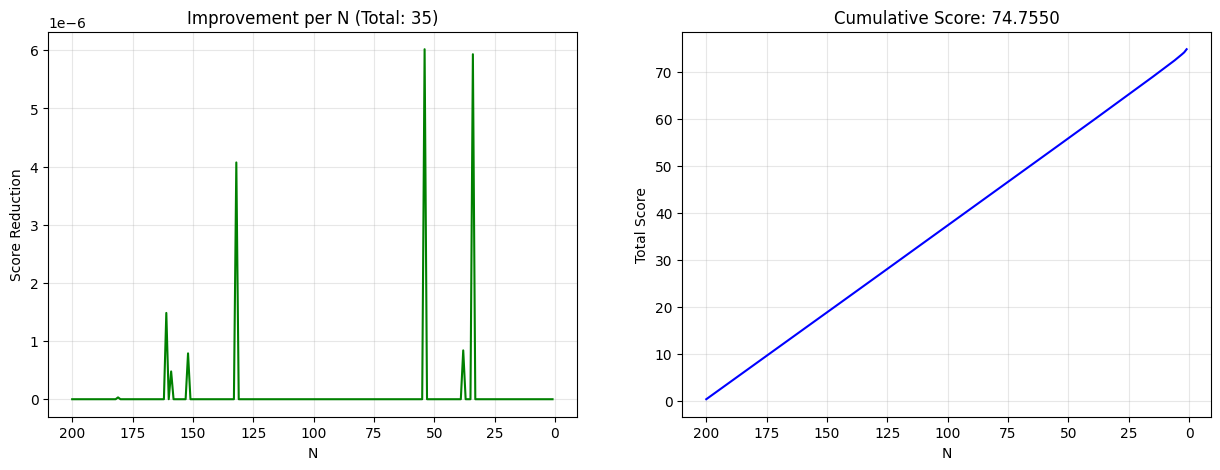

Processing Reverse:   0%|          | 0/200 [00:00<?, ?it/s]


--- Processing N=200 ---
  [N=200] Launching 4 parallel tasks...
  [N=200] Best candidate score: 0.371064
  [N=200] Baseline score: 0.371064
  [N=200] !!! Reverse Search Found Improvement! 0.371064 -> 0.371064
  [N=200] Finished. Cumulative Score: 0.371064 | Total Improvements: 1
  [N=200] Best candidate score: 0.371064
  [N=200] Baseline score: 0.371064
  [N=200] !!! Reverse Search Found Improvement! 0.371064 -> 0.371064
  [N=200] Finished. Cumulative Score: 0.371064 | Total Improvements: 1

--- Processing N=199 ---
  [N=199] Launching 4 parallel tasks...

--- Processing N=199 ---
  [N=199] Launching 4 parallel tasks...
  [N=199] Best candidate score: 0.372924
  [N=199] Baseline score: 0.369846
  [N=199] Baseline is better. Attempting to optimize baseline...
  [N=199] Best candidate score: 0.372924
  [N=199] Baseline score: 0.369846
  [N=199] Baseline is better. Attempting to optimize baseline...
  [N=199] Could not improve baseline.
  [N=199] Finished. Cumulative Score: 0.740910 | T

In [8]:
from joblib import Parallel, delayed
import multiprocessing
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import os
import datetime

# Load baseline from test.csv
known_solutions = {}
try:
    print("Loading baseline from test.csv...")
    baseline_df = pd.read_csv('test.csv')
    
    def parse_s(val):
        return float(str(val).replace('s', ''))
    
    baseline_df['x'] = baseline_df['x'].apply(parse_s)
    baseline_df['y'] = baseline_df['y'].apply(parse_s)
    baseline_df['deg'] = baseline_df['deg'].apply(parse_s)
    
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        rows = baseline_df[baseline_df['id'].str.startswith(prefix)]
        if len(rows) == n:
            trees = []
            for _, row in rows.iterrows():
                trees.append(ChristmasTree(row['x'], row['y'], row['deg']))
            known_solutions[n] = trees
            
    print(f"Loaded {len(known_solutions)} configurations from test.csv")
    
except Exception as e:
    print(f"Could not load baseline: {e}")

# Helper function for parallel execution (REVERSE MODE)
def process_beam_candidate_reverse(base_trees, n, packer_params, target_side=None):
    """
    Takes a solution of size >= n.
    If size > n, removes trees to reach size n.
    Then optimizes.
    """
    current_trees = [ChristmasTree(t.center_x, t.center_y, t.angle) for t in base_trees]
    
    # Remove trees if needed (Shrink strategy)
    while len(current_trees) > n:
        # Heuristic: Remove a tree that contributes to the bounds (on the edge)
        # Find bounds
        if not current_trees: break
        minx, miny, maxx, maxy = unary_union([t.polygon for t in current_trees]).bounds
        
        # Find trees touching bounds
        candidates_to_remove = []
        for i, t in enumerate(current_trees):
            tb = t.polygon.bounds
            # Check if close to global bounds (epsilon)
            if (abs(tb[0] - minx) < 1e-3 or abs(tb[1] - miny) < 1e-3 or 
                abs(tb[2] - maxx) < 1e-3 or abs(tb[3] - maxy) < 1e-3):
                candidates_to_remove.append(i)
        
        if candidates_to_remove:
            idx = random.choice(candidates_to_remove)
        else:
            idx = random.randint(0, len(current_trees) - 1)
            
        current_trees.pop(idx)
    
    # Optimize
    # Use slightly more aggressive params since we are shrinking and want to fill gaps
    candidate_trees = optimize_packing(current_trees, {'iterations': 1000, 'step_size': 0.3, 'angle_step': 15.0, 'initial_temp': 0.2}, target_side=target_side)
        
    # Score Candidate
    side_candidate = get_bounds(candidate_trees)
    score_candidate = (side_candidate ** 2) / n
    
    return (score_candidate, candidate_trees)

# BEAM SEARCH PARAMETERS
BEAM_WIDTH = 12       # Keep top 12 candidates
BRANCH_FACTOR = 4     # Generate 4 children per candidate
n_jobs = multiprocessing.cpu_count()
print(f"Running Reverse Beam Search (200 -> 1) (Width={BEAM_WIDTH}, Branch={BRANCH_FACTOR}) on {n_jobs} cores.")

packer_params = {'n_trials': 200, 'step_size': 0.2, 'fine_step': 0.01}

all_solutions = {}
submission_rows = []
improvements = 0

# Initialize candidates with the solution for N=200
if 200 in known_solutions:
    print("Initializing with known solution for N=200.")
    current_candidates = [known_solutions[200]]
else:
    print("ERROR: No solution for N=200 found in baseline. Cannot start reverse search.")
    current_candidates = []

# Metrics Tracking
history_n = []
history_improvement = []
history_total_score = []
current_total_score = 0

# Setup Metrics File
os.makedirs('Data', exist_ok=True)
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
metrics_file = f'Data/run_metrics_reverse_{timestamp_str}.csv'
with open(metrics_file, 'w') as f:
    f.write('n,score,baseline,improvement,source\n')

# Setup Realtime Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.close(fig) # Don't show yet
plot_display_id = "metrics_plot_dynamic"
display(fig, display_id=plot_display_id) # Show initial empty plot

# REVERSE LOOP: 200 down to 1
for n in tqdm(range(200, 0, -1), desc="Processing Reverse"):
    
    print(f"\n--- Processing N={n} ---")

    # Get baseline side for pruning/comparison
    baseline_side = None
    if n in known_solutions:
        baseline_side = get_bounds(known_solutions[n])
    
    # 1. Expand candidates in parallel
    # We generate BRANCH_FACTOR children for EACH candidate in the current beam
    tasks = []
    for base_trees in current_candidates:
        for _ in range(BRANCH_FACTOR):
            tasks.append((base_trees, n, packer_params, baseline_side))
            
    print(f"  [N={n}] Launching {len(tasks)} parallel tasks...")
    
    # Run in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_beam_candidate_reverse)(t[0], t[1], t[2], t[3]) for t in tasks
    )
    
    # 2. Sort and select top K (Beam Selection)
    results.sort(key=lambda x: x[0])
    print(f"  [N={n}] Best candidate score: {results[0][0]:.6f}")
    
    # Update current candidates for next iteration (which is n-1)
    unique_candidates = []
    seen_scores = set()
    for res in results:
        s = round(res[0], 6)
        if s not in seen_scores:
            unique_candidates.append(res[1])
            seen_scores.add(s)
        if len(unique_candidates) >= BEAM_WIDTH:
            break
            
    current_candidates = unique_candidates
    
    # The best candidate for this N
    best_score_greedy = results[0][0]
    best_trees_greedy = results[0][1]
    
    # 3. Compare with Baseline
    best_trees_n = best_trees_greedy
    best_score_n = best_score_greedy
    source = "ReverseGreedy"
    baseline_val = 0
    
    if n in known_solutions:
        known_trees = known_solutions[n]
        known_trees = center_packing(known_trees)
        side_known = get_bounds(known_trees)
        score_known = (side_known ** 2) / n
        baseline_val = score_known
        
        print(f"  [N={n}] Baseline score: {score_known:.6f}")

        # Compare (Lower is better)
        if score_known < best_score_greedy - 1e-9:
            best_trees_n = known_trees
            best_score_n = score_known
            source = "Baseline"
            print(f"  [N={n}] Baseline is better. Attempting to optimize baseline...")
            
            # Optimize Baseline
            optimized_known = [ChristmasTree(t.center_x, t.center_y, t.angle) for t in known_trees]
            optimized_known = optimize_packing(optimized_known, {
                'iterations': 15000, 
                'step_size': 0.5, 
                'angle_step': 10.0, 
                'initial_temp': 1.0,
                'compression': 0.05
            })
            
            side_opt = get_bounds(optimized_known)
            score_opt = (side_opt ** 2) / n
            
            if score_opt < score_known - 1e-9:
                best_trees_n = optimized_known
                best_score_n = score_opt
                source = "Baseline+Opt"
                improvements += 1
                print(f"  [N={n}] !!! Baseline Optimized! {score_known:.6f} -> {score_opt:.6f}")
            else:
                print(f"  [N={n}] Could not improve baseline.")
                
            # Inject baseline into beam
            current_candidates.append(best_trees_n)
            # Re-sort beam
            temp_candidates = []
            for c in current_candidates:
                s = get_bounds(c)
                temp_candidates.append(((s**2)/n, c))
            temp_candidates.sort(key=lambda x: x[0])
            current_candidates = [x[1] for x in temp_candidates[:BEAM_WIDTH]]
            
        else:
            print(f"  [N={n}] !!! Reverse Search Found Improvement! {score_known:.6f} -> {best_score_greedy:.6f}")
            improvements += 1
            
    # 4. Update State & Check Bounds
    all_solutions[n] = best_trees_n
    
    for t in best_trees_n:
        if abs(t.center_x) > 100 or abs(t.center_y) > 100:
            print(f"WARNING: Tree at N={n} outside bounds: ({t.center_x:.2f}, {t.center_y:.2f})")
    
    # 5. Metrics & Plotting
    current_total_score += best_score_n
    imp = max(0, baseline_val - best_score_n) if baseline_val > 0 else 0
    
    print(f"  [N={n}] Finished. Cumulative Score: {current_total_score:.6f} | Total Improvements: {improvements}")

    history_n.append(n)
    history_improvement.append(imp)
    history_total_score.append(current_total_score)
    
    # Save metrics
    with open(metrics_file, 'a') as f:
        f.write(f"{n},{best_score_n:.10f},{baseline_val:.10f},{imp:.10f},{source}\n")
        
    # Realtime Plot (Update every 5 steps)
    if n % 5 == 0 or n == 1:
        # Update axes
        ax1.clear()
        ax2.clear()
        
        # Note: history_n is decreasing [200, 199, ...]
        ax1.plot(history_n, history_improvement, 'g-', label='Improvement')
        ax1.set_title(f'Improvement per N (Total: {improvements})')
        ax1.set_xlabel('N')
        ax1.set_ylabel('Score Reduction')
        ax1.invert_xaxis() # Invert X axis to show 200 -> 1 flow
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(history_n, history_total_score, 'b-', label='Total Score')
        ax2.set_title(f'Cumulative Score: {current_total_score:.4f}')
        ax2.set_xlabel('N')
        ax2.set_ylabel('Total Score')
        ax2.invert_xaxis()
        ax2.grid(True, alpha=0.3)
        
        # Update the display
        display(fig, display_id=plot_display_id, update=True)
    
    # 6. Prepare Submission Rows
    for i, tree in enumerate(best_trees_n):
        submission_rows.append([
            f"{n:03d}_{i}", 
            f"s{tree.center_x:.10f}", 
            f"s{tree.center_y:.10f}", 
            f"s{tree.angle:.10f}"
        ])

print(f"Processing complete. Improvements over baseline/initial: {improvements}")

df_sub = pd.DataFrame(submission_rows, columns=['id', 'x', 'y', 'deg'])
# Sort by ID to ensure 001_... comes first
df_sub.sort_values('id', inplace=True)
df_sub.to_csv('submission.csv', index=False)
print("Submission generated.")

In [9]:
import matplotlib.pyplot as plt
import os

# Create images directory
os.makedirs('images', exist_ok=True)

def save_comparison_image(n, trees, baseline_trees, filename):
    # Determine if we have a baseline to compare against
    has_baseline = baseline_trees is not None
    
    if has_baseline:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        ax_new = axes[1]
        ax_base = axes[0]
    else:
        fig, ax_new = plt.subplots(1, 1, figsize=(10, 10))
        ax_base = None

    # Helper to plot trees on an axis
    def plot_on_ax(ax, tree_list, title):
        if not tree_list: return
        
        # Calculate bounds for this specific set
        minx, miny, maxx, maxy = unary_union([t.polygon for t in tree_list]).bounds
        side = max(maxx - minx, maxy - miny)
        score = (side ** 2) / len(tree_list)
        
        # Plot trees
        for i, tree in enumerate(tree_list):
            x, y = tree.polygon.exterior.xy
            # Color logic: Last tree (newest) is distinct
            if i == len(tree_list) - 1:
                color = 'red' # Newest generation
                alpha = 0.9
            else:
                color = 'forestgreen' # Old generations
                alpha = 0.6
                
            ax.fill(x, y, alpha=alpha, fc=color, ec='darkgreen')
            
        ax.set_aspect('equal')
        ax.set_title(f"{title}\nScore: {score:.6f} | Side: {side:.6f}")
        ax.set_xlim(minx - 1, maxx + 1)
        ax.set_ylim(miny - 1, maxy + 1)

    # Plot New Solution
    plot_on_ax(ax_new, trees, f"New Solution N={n}")
    
    # Plot Baseline if exists
    if has_baseline:
        plot_on_ax(ax_base, baseline_trees, f"Baseline N={n}")
    
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)

print("Generating comparison images...")
for n, trees in tqdm(all_solutions.items(), desc="Generating Images"):
    baseline = known_solutions.get(n)
    save_comparison_image(n, trees, baseline, f"images/solution_{n:03d}.png")
    
print("Images generated in 'images/' directory.")

Generating comparison images...


Generating Images:   0%|          | 0/200 [00:00<?, ?it/s]

Images generated in 'images/' directory.


## 9. Evaluation Helper

Calculate the local score to estimate leaderboard performance.

In [11]:
import os
import datetime

# Calculate final score
final_score = 0
for n, trees in all_solutions.items():
    side = get_bounds(trees)
    final_score += (side ** 2) / n

print(f"Final Score: {final_score:.10f}")

# Compare with original
if 'total_test_score' in globals():
    print(f"Original Score: {total_test_score:.10f}")
    if final_score < total_test_score:
        diff = total_test_score - final_score
        print(f"SUCCESS: Score improved by {diff:.10f}!")
        
        # 1. Save copy with detailed name
        os.makedirs('Data', exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        detailed_name = f"Data/submission_score{final_score:.2f}_improved{diff:.2f}_{timestamp}.csv"
        df_sub.to_csv(detailed_name, index=False)
        print(f"Saved backup: {detailed_name}")
        
        # 2. Overwrite test.csv
        df_sub.to_csv('test.csv', index=False)
        print("Overwrote test.csv")
        
        # 3. Submit to Kaggle
        message = f"Improved score {final_score:.6f} (was {total_test_score:.6f})"
        print("Submitting to Kaggle...")
        !kaggle competitions submit -c santa-2025 -f submission.csv -m "{message}"

        # 4. Git Commit and Push
        print("Committing and pushing to Git...")
        !git add .
        !git commit -m "{message}"
        !git push
        
    else:
        print(f"No improvement (Current: {final_score:.10f} >= Original: {total_test_score:.10f}).")
else:
    print("Original score not found. Run the first cell to load test.csv baseline.")

Final Score: 74.7550348256
Original score not found. Run the first cell to load test.csv baseline.
